In [1]:
from adam import ADAM
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap
import numpy as np
from qiskit.quantum_info import Statevector
from math import log
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

In [2]:
X, y = make_blobs(n_samples=100, centers=2, n_features=4, random_state=0)

In [3]:
x1_train = [X[i] for i in range(len(X)) if y[i] == 0]
x2_train = [X[i] for i in range(len(X)) if y[i] == 1]

x1_train = np.array(x1_train)
x2_train = np.array(x2_train)

In [4]:
# size of training data set
training_size = 100
# dimension of data sets
n = 2

training_input = {'A':x1_train, 'B':x2_train}
class_labels = ['A', 'B']

In [5]:
sv = Statevector.from_label('0' * n)

In [6]:
def final_circuit(circuit, data, params):
    angle_y = ((np.pi-data[0])*(np.pi-data[1]))
    angle_z = ((np.pi-data[2])*(np.pi-data[3]))
    for i in range(n):
        circuit.h(i)
        circuit.ry(data[i], i)
        circuit.rz(data[i+2],i)
    circuit.cx(0,1)
    circuit.ry(angle_y, 0)
    circuit.rz(angle_z, 1)
    circuit.cx(0,1)
    for i in range(n):
        circuit.ry(params[i],i)
    circuit.barrier()
    circuit.cx(0,1)
    for i in range(n):
        circuit.ry(data[i], i)
        circuit.rz(data[i+2],i)
    circuit.cx(0,1)
    circuit.ry(angle_y, 0)
    circuit.rz(angle_z, 1)
    circuit.cx(0,1)
    for i in range(n):
        circuit.ry(params[i+2],i)

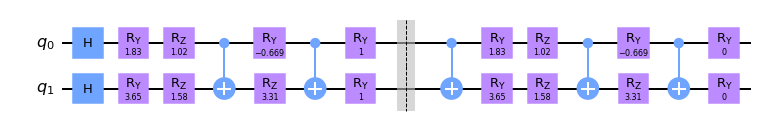

In [7]:
cir = QuantumCircuit(2)
final_circuit(cir, x1_train[0],[1,1,0,0,-1,-1,0,0,1,1])
cir.draw('mpl')

In [9]:
def assign_label(bit_string, class_labels):
    hamming_weight = sum([int(k) for k in list(bit_string)])
    is_odd_parity = hamming_weight & 1
    if is_odd_parity:
        return class_labels[1]
    else:
        return class_labels[0]

def return_probabilities(counts, class_labels):
    shots = sum(counts.values())
    result = {class_labels[0]: 0,
              class_labels[1]: 0}
    for key, item in counts.items():
        label = assign_label(key, class_labels)
        result[label] += counts[key]/shots
    return result

def classify(x_list, params, class_labels):
    qc_list = []
    for x in x_list:
        circuit = QuantumCircuit(n)
        circ_ = final_circuit(circuit, x, params)
        qc = sv.evolve(circuit)
        qc_list += [qc]
    probs = []
    for qc in qc_list:
        counts = qc.probabilities_dict()
        prob = return_probabilities(counts, class_labels)
        probs += [prob]
    return probs


def CrossEntropy(yHat, y):
    if y == 'A':
      return -log(yHat['A'])
    else:
      return -log(1-yHat['A'])


def cost_function(training_input, class_labels, params, shots=100, print_value=False):
    # map training input to list of labels and list of samples
    cost = 0
    training_labels = []
    training_samples = []
    for label, samples in training_input.items():
        for sample in samples:
            training_labels += [label]
            training_samples += [sample]

    # classify all samples
    probs = classify(training_samples, params, class_labels)

    # evaluate costs for all classified samples
    for i, prob in enumerate(probs):
        cost += CrossEntropy(yHat=prob, y=training_labels[i])
    cost /= len(training_samples)

    # return objective value
    #print(cost)
    return cost


# setup the optimizer
optimizer = ADAM(maxiter=100, lr=0.1)

# define objective function for training
objective_function = lambda params: cost_function(training_input, class_labels, params, print_value=True)

d = 4  # num of trainable params
for i in range(100):
    print(i)
    np.random.seed(i)
    # randomly initialize the parameters
    init_params = np.random.uniform(-1,1,d)
    print(init_params)
    # train classifier
    #init_params = np.random.uniform(-1,1,2)
    opt_params, value, _, loss = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
    print(loss)
    print(opt_params)
    # print results
    f1 = 'Data/2Layers/Layer2Hard/quantum_loss_hard_layer2blobs_%d.npy' %i
    f2 = 'Data/2Layers/Layer2Hard/opt_params_hard_layer2blobs_%d.npy'%i
    np.save(f2, opt_params)
    np.save(f1, loss)

0
[0.09762701 0.43037873 0.20552675 0.08976637]
[0.8144719510272576, 0.8048233640284582, 0.7977941840771208, 0.7907892945849225, 0.7832639946882398, 0.7756368286883459, 0.7679841056442477, 0.7601426861265659, 0.7524458875648683, 0.7461421520498351, 0.742914589141193, 0.7433900980453589, 0.7459893178200824, 0.7485666920531087, 0.7500512131327182, 0.7500877384604274, 0.7487878041617317, 0.7466887979636547, 0.7444835932452897, 0.7425569111119014, 0.7407463836931512, 0.738653959800084, 0.7361371349270749, 0.7334072315127874, 0.7307225189003617, 0.7279749830208356, 0.7245086860195517, 0.7194886049097191, 0.7127801296685762, 0.7055950468728356, 0.699789241747887, 0.6962667677551145, 0.6943676117779166, 0.6928487624960326, 0.6909505478759135, 0.6885855642994919, 0.6861983670452826, 0.6845476805141201, 0.6842400065654891, 0.6851476942339886, 0.6863831367685022, 0.6870840080197835, 0.6870439648802563, 0.6865347979414129, 0.685844589902992, 0.6850909560029866, 0.6843247654606146, 0.6836529723409

[0.8478515073641824, 0.8414187337831862, 0.8404500801649551, 0.8354832663340891, 0.8276135329923647, 0.8202956721278377, 0.8151700968851187, 0.8127070514561826, 0.8117817423889765, 0.8103947124364181, 0.8069010713343364, 0.8005030607350524, 0.791584520023911, 0.781533338973223, 0.7716662624475917, 0.7624851085502997, 0.7538514350086661, 0.7453680792141806, 0.7365814759788749, 0.7274742059900838, 0.71893847876301, 0.7117990328381238, 0.7055702871642409, 0.6988153560870299, 0.6902437620511024, 0.6793778492944514, 0.667182094745473, 0.655562353339663, 0.6460004268017038, 0.6393547878493172, 0.6362213245304339, 0.6366316124367389, 0.6394399287078119, 0.6425602210203657, 0.6441488356605225, 0.6435719546279438, 0.6413917883630649, 0.6386756496152549, 0.6363273543490776, 0.6348098384630897, 0.6341785939608902, 0.6342254364962314, 0.6346157372567811, 0.6349932844581039, 0.6350571006055661, 0.6346128832297027, 0.6335997587556821, 0.6321032229526784, 0.6303601095309758, 0.6287300030867382, 0.627

[0.8408181454492062, 0.8271469314050708, 0.8152044873441362, 0.8070620602628437, 0.803289377039581, 0.8020622129414398, 0.8012946731388985, 0.8003652701704159, 0.7993040473920314, 0.7980625148363742, 0.7963372468158613, 0.7936022113811535, 0.789202274066496, 0.7828900258653695, 0.7755454695630296, 0.7686142908493454, 0.7627153466206756, 0.7570991568995317, 0.7508944483910619, 0.7443076847760909, 0.7381919438625201, 0.7331288978565486, 0.7289004768450427, 0.7245752248249352, 0.7192020169342725, 0.7125547330309984, 0.7051797526184583, 0.6980263596079733, 0.6920966002932696, 0.6880965925368053, 0.6861056645165966, 0.6855192150076317, 0.6855037711805687, 0.6857008344342244, 0.6863332689113036, 0.6875726260501414, 0.6891431777263449, 0.6904987994385045, 0.6911530380971541, 0.6908717035202783, 0.6896922837744017, 0.6878570084688195, 0.6857320914071002, 0.6837249609015764, 0.6821862595733635, 0.6813087960905753, 0.6810749397689881, 0.6812976661387831, 0.6817319523432684, 0.6821784960863557, 0

[0.8192756458785792, 0.8129811020586789, 0.807322735209534, 0.802419766525125, 0.7981374539507603, 0.7944285864600689, 0.7898287032290732, 0.7821352118092406, 0.7724004736587105, 0.7642224630696218, 0.7584965828723047, 0.7533767712343363, 0.7487623882954147, 0.7456118224947444, 0.7441688541010235, 0.743728854960767, 0.7433628860928003, 0.7423073146259417, 0.7400060565373525, 0.7362219899016681, 0.7309704802980486, 0.7242419269221189, 0.7160694552387187, 0.7072379837333104, 0.6996144742524427, 0.6951269428927732, 0.6944221622502379, 0.6963013773086302, 0.698319190917584, 0.6983927347029534, 0.6959796589350191, 0.6920431326939009, 0.688131307942291, 0.6854210190685999, 0.6843102289104833, 0.6844790598003194, 0.6852706682363096, 0.686111122800641, 0.6866763482387936, 0.686837865724165, 0.6865750852067576, 0.6859406988200537, 0.6850587363819508, 0.6841057935597671, 0.6832561466170791, 0.6826206938785302, 0.682222771514071, 0.682021055893349, 0.6819513375271646, 0.6819575410755323, 0.682001

[0.8365796624827503, 0.8233750725044087, 0.8071081741271223, 0.7835914618266787, 0.7621197693780847, 0.7455356832950855, 0.7342774313820973, 0.728155925152113, 0.7258165859328848, 0.7250218147717625, 0.7239878958144633, 0.7221567503285107, 0.7196742561626782, 0.7168104002870156, 0.7137859555910951, 0.7107477431619093, 0.7078200911623891, 0.7052215518087283, 0.7032735775071731, 0.7022493279054649, 0.7022390799898842, 0.7031054631761587, 0.7044667145139039, 0.7057910538253139, 0.7066410706555287, 0.7068527448730937, 0.7065221408240696, 0.7058898276901145, 0.7052227295608131, 0.7047222220812881, 0.7044643615774433, 0.7043873760094829, 0.7043383988722587, 0.7041614954475321, 0.7037792733746647, 0.7032270089361687, 0.7026311586334814, 0.7021492279617787, 0.7018984996490444, 0.7019036380385418, 0.7020876851471468, 0.7023127675707379, 0.702448256471299, 0.7024284422698208, 0.70227165609149, 0.7020580236019484, 0.7018833784419969, 0.701812868815718, 0.7018548157069737, 0.701964543370305, 0.702

[0.802864653670137, 0.7927446416553058, 0.7838270673689278, 0.7737627629386288, 0.7624838307887254, 0.7514014748599024, 0.7427761277629269, 0.7381300137582979, 0.7370675459921598, 0.7374387420933826, 0.7373617139182024, 0.736347604469352, 0.7345930377348457, 0.7322906181169526, 0.7295043096001699, 0.7262814562465181, 0.722764920416242, 0.7192236191213035, 0.7159975956691917, 0.7134071129365265, 0.7116825718086405, 0.7109246750709876, 0.7110728811375074, 0.7118951515106384, 0.7130458251363697, 0.714183166061777, 0.715060821765274, 0.7155446760492051, 0.7155934366753123, 0.7152430546119922, 0.7145907129827956, 0.7137680235193531, 0.7129147980581824, 0.7121584941296513, 0.711590848346587, 0.7112434428865404, 0.711085555907867, 0.711051465451116, 0.711074625181507, 0.7111079383976134, 0.7111304673058401, 0.7111457090909554, 0.7111694614342603, 0.7112111194661489, 0.7112638798609952, 0.7113097886088242, 0.7113283226292587, 0.7113017537119695, 0.7112218788306645, 0.7110963437714269, 0.710945

[0.8451899881260796, 0.8418353789480103, 0.8351437497014238, 0.8265880730994577, 0.8180565024300482, 0.810869312529789, 0.8059062538569868, 0.8027821478830383, 0.8000024589825143, 0.7963686568302049, 0.7913998559682157, 0.7852686513252567, 0.7788454514212144, 0.7735376185882477, 0.7704819945617766, 0.7695219912971926, 0.7693569561060801, 0.7687455070193788, 0.7671217105739708, 0.7644768869372958, 0.7610348795928342, 0.7570413700376036, 0.7527355328032027, 0.7484192234688072, 0.7444747089652861, 0.7412039544553278, 0.7383499822336649, 0.7343239637647534, 0.7268055265540627, 0.7166614483902981, 0.707187550918199, 0.6992588313075487, 0.691733196431901, 0.6839315363052368, 0.6763450029488476, 0.6698022122641686, 0.6647051164273293, 0.6609714792376732, 0.6583225218203461, 0.6564974670452662, 0.6552769861564489, 0.6543687234477338, 0.6532960825245678, 0.6514619734072441, 0.6484256287301645, 0.6442042857466841, 0.6393540330939045, 0.6347541877114113, 0.6312315123387782, 0.6292491146926494, 0.

[0.8676684748963693, 0.8472880159881306, 0.8329977261743114, 0.8239426302816536, 0.8194535512214413, 0.8194195101547741, 0.8219344630398042, 0.824603164631092, 0.8259169916888258, 0.8252208221558551, 0.8224783359128583, 0.8181466190095942, 0.8127619762758017, 0.8063995266086382, 0.798939825556183, 0.7906674979764158, 0.7821458495954328, 0.773965474761058, 0.7667180755916014, 0.7608640874232728, 0.7564814703315134, 0.7531804415530403, 0.7503562725166927, 0.7475376654421733, 0.7444914439709158, 0.741054448973372, 0.7367978456906848, 0.7307919886347275, 0.7223490751312553, 0.7124697564672066, 0.7029862967216546, 0.6949093400022086, 0.688293278636015, 0.6826102273392385, 0.6771636623802025, 0.6715408408734389, 0.665817654211332, 0.6603426705671968, 0.655383338250859, 0.6509443699587546, 0.646836741625185, 0.6428750797987623, 0.6390198194308723, 0.6354042976105024, 0.6322906086883002, 0.6299654933101219, 0.6285969695770107, 0.6281481419701815, 0.6284174610198564, 0.6291496219313477, 0.63011

[0.9075636944071426, 0.881274873356812, 0.8598718273127554, 0.841548122062281, 0.8262539917606019, 0.8131536850605404, 0.8016301632471164, 0.7921800817756172, 0.7854929870026156, 0.781810488032448, 0.780783803424083, 0.7816237563877425, 0.7834427680336786, 0.7855285085503617, 0.7874194693693031, 0.7888528554194122, 0.7896781279165249, 0.7897861259615477, 0.7890725856147265, 0.7874514562531555, 0.7849294941708588, 0.7817215130877706, 0.7783020020122858, 0.7752453305785879, 0.7728466259452227, 0.7708132355881091, 0.7684034490018996, 0.7649236677052295, 0.7600423558718665, 0.7537100504038824, 0.7459802473895073, 0.7371195042679167, 0.727974329716487, 0.7199577457787458, 0.7144688967319651, 0.7122908038786133, 0.7132922850799563, 0.7164679406741082, 0.7203100775347852, 0.7233856656765666, 0.7248066779498217, 0.7243637474960971, 0.7223879272678317, 0.7195173025595463, 0.7164705969417889, 0.7138700042973397, 0.7121311601171201, 0.711410408405695, 0.7116017710131398, 0.7123927181157863, 0.713

[0.8409590622524418, 0.8298833065872864, 0.81215603709954, 0.7909079766587008, 0.7708885314606104, 0.7557913029783364, 0.7468716937028995, 0.7421047758218094, 0.7389023891500769, 0.7357075365187442, 0.7329532987494995, 0.7322350489656441, 0.7340694713518126, 0.7371369700518103, 0.7396632840260388, 0.7407800427104729, 0.74046624294172, 0.7390765542746867, 0.737083768190685, 0.7349643749106022, 0.7331075125777267, 0.731733134245025, 0.7308719012031848, 0.7304126649402165, 0.7301446754515183, 0.7298065692521136, 0.7292362570789771, 0.7285210813484143, 0.7279353706571673, 0.7277209307487056, 0.7279311934368898, 0.7284249646752804, 0.728963496025507, 0.7293280132505991, 0.7293938724499504, 0.7291465687771186, 0.7286608927069228, 0.7280657365195737, 0.7275044397223744, 0.727094166491312, 0.7268904440547266, 0.7268727332951513, 0.7269637392464855, 0.7270746815240251, 0.7271475239764195, 0.7271690812206143, 0.7271569093386197, 0.727135827918416, 0.727120623192171, 0.7271104149070229, 0.7270930

[0.7770735177930608, 0.7554949586774101, 0.7388727022427123, 0.7282290041302472, 0.7237969346059043, 0.7237613180808836, 0.724392374774376, 0.7229373174746647, 0.7197171925712298, 0.7164509138812069, 0.7141577815789465, 0.7129819841639047, 0.7126220656934795, 0.7126249857394295, 0.712545293200143, 0.712062178389725, 0.7110421770355431, 0.7095269809742955, 0.7076829031337408, 0.7057561515576961, 0.7040377630776973, 0.7028156917371067, 0.7023005969236871, 0.7025446123487005, 0.7033896783366678, 0.704485257217851, 0.7054022247612476, 0.7058068262783546, 0.7055884680986024, 0.7048665519439674, 0.7038990098902573, 0.7029622544953894, 0.7022588178593765, 0.7018778455661532, 0.7018038651415831, 0.7019522194209956, 0.702209831623704, 0.7024690649284089, 0.7026499843867675, 0.7027109046846356, 0.7026486485328579, 0.702490694119019, 0.7022831263349871, 0.7020766255534677, 0.7019140787698882, 0.7018217019699736, 0.7018046227967156, 0.7018472925886233, 0.7019187675587402, 0.7019824780448871, 0.702

44
[ 0.6696843  -0.79040779  0.48928096 -0.27899833]
[0.8745630054963286, 0.8461393420052474, 0.8269790012497541, 0.8150612314723191, 0.8049487991658048, 0.7912690638647895, 0.773134958870078, 0.7549723907015838, 0.7410008123025116, 0.7331606355931306, 0.7313872605855464, 0.7340069485862973, 0.738433108764561, 0.7422904374391552, 0.7443255725209571, 0.7444375246174405, 0.7431196371910335, 0.7409759824646991, 0.7385370909164224, 0.7362490393970978, 0.7344669312284552, 0.7333914036688232, 0.7330075815546813, 0.7331055142621564, 0.7333855015666562, 0.7335767859842955, 0.7335037416578483, 0.7330942765651821, 0.7323610699892433, 0.7313781666539074, 0.7302588135290248, 0.7291347380431578, 0.7281383653728281, 0.7273855276509873, 0.7269536615180457, 0.7268582971963586, 0.7270434775821818, 0.7273974304804227, 0.727788136715517, 0.7281007089334802, 0.7282618150253412, 0.7282482150410376, 0.7280829987165772, 0.7278234865672196, 0.7275423069801399, 0.7273051074477792, 0.7271509966596306, 0.7270844

[0.8325989628336032, 0.8239434264651725, 0.8156127428331936, 0.8077533388142905, 0.8009614777654727, 0.7951644759015651, 0.7894667188475125, 0.7835167125746634, 0.7783781923179767, 0.7745692604075677, 0.7707871548830538, 0.7656888845926061, 0.7591268150451849, 0.7521439591038036, 0.746193502700308, 0.7423585350635774, 0.7409804806574694, 0.7416176984493933, 0.7432117811002042, 0.7444405962964038, 0.7442264672596886, 0.7420448347737463, 0.7378418708533974, 0.7318292127390551, 0.7244805419788998, 0.7166657417522937, 0.7095683071725604, 0.7043083970790085, 0.7014202333556047, 0.700454868243315, 0.7001169210178168, 0.6989632910878801, 0.6961688533140457, 0.6918989355987599, 0.6871867708998216, 0.6833947328668554, 0.6815480785933452, 0.6819121857821483, 0.6839387130763553, 0.686545147538213, 0.6886147636267027, 0.6894473923562948, 0.6889145990982677, 0.6873389060502426, 0.685266922669847, 0.6832631389524412, 0.6817686224599236, 0.6810203592032837, 0.6810182542298174, 0.6815485485808841, 0.6

[1.0561312097094504, 1.000259151296526, 0.9561844205933263, 0.9234684510895924, 0.8993823625405802, 0.8807666535197062, 0.8653601049646028, 0.8520426114794378, 0.840707626186047, 0.8317655968159517, 0.8255220535584687, 0.821933372495376, 0.8206213820020216, 0.8209414313834331, 0.8221011934099429, 0.8233305291421498, 0.82401877254691, 0.8237740412994201, 0.8224286076020306, 0.8200104945232843, 0.816674326210718, 0.8126020074596351, 0.8079161394225323, 0.8026463467460965, 0.796765381578053, 0.7902890332324334, 0.7833834717308392, 0.7763761734411437, 0.769650143526696, 0.7635304594446096, 0.7582451934232151, 0.7539357140387546, 0.7506612237838826, 0.748381514522356, 0.7469430810328613, 0.7460990729332767, 0.7455644289833063, 0.7450799983123865, 0.7444580801263033, 0.7435988733799884, 0.7424811415004943, 0.7411356002370003, 0.7396093119164816, 0.7379261081935968, 0.7360453482867385, 0.7338191976158724, 0.7309599331581081, 0.7270781887776734, 0.7219080007758297, 0.7156448118004232, 0.708953

[0.884865859814909, 0.8668001211010568, 0.8561370322657984, 0.8505467927161624, 0.8475698735702317, 0.8450972538357966, 0.8413736873938666, 0.8352271028718189, 0.8260954333422277, 0.8141133308072314, 0.8006563843228777, 0.7880326837008254, 0.7783899073076158, 0.7730898657066123, 0.772298837881041, 0.7747276782164759, 0.7782604227302886, 0.7810860704363368, 0.7822084260334159, 0.7813610986579235, 0.7787498621395287, 0.7748313165221152, 0.7701675943481683, 0.765320027023714, 0.760761550566055, 0.7568157083717953, 0.7536293462595343, 0.7511731815456638, 0.7492657738175923, 0.7476355455420761, 0.7460262306217682, 0.7442863152232627, 0.7423527464731123, 0.7401097758815094, 0.7371355958779842, 0.7323677932527844, 0.7243299814129037, 0.7132517665154648, 0.7016704709731819, 0.6915867402844872, 0.683613221573976, 0.6774485322852196, 0.6723540583885417, 0.6676738981333284, 0.6631122186633273, 0.6586616512407469, 0.654433284514287, 0.6505412696491333, 0.64704798348926, 0.6439430913013385, 0.64115

[0.8701872550704599, 0.8476557323794713, 0.8266304121466398, 0.808281951421705, 0.7952865380465792, 0.7891476339969583, 0.7885919009294795, 0.789929754352261, 0.7903766840559839, 0.7891235104859176, 0.7863146236721483, 0.7823392366077303, 0.7774837055031825, 0.771750160738871, 0.7648587565815926, 0.7566460791147215, 0.7475732458024505, 0.7384987152690752, 0.7300585127581841, 0.7225694748546537, 0.7163469651355392, 0.7117832461422772, 0.7090123735085365, 0.70763771930441, 0.7068734716715298, 0.7059240332256718, 0.7042771040193645, 0.7018032538764299, 0.6986884469258304, 0.6952733267347893, 0.6919089408774229, 0.6888795963204223, 0.6863705040539569, 0.6844731045396136, 0.6832280726617712, 0.6826600526280366, 0.6827574361606351, 0.6834194215393439, 0.6844356855604607, 0.6855261848420868, 0.686416176761242, 0.6869074872660268, 0.6869175666050947, 0.686478317787548, 0.6857052486477353, 0.6847528071701926, 0.6837711437919904, 0.6828746543188728, 0.6821286421930728, 0.68155591199166, 0.681155

[0.8099205346608006, 0.795981673173605, 0.7861638718467147, 0.7802734932060974, 0.777257911866662, 0.7750144695057718, 0.7708050278159368, 0.7635392148243468, 0.7547437859425103, 0.7463538103076072, 0.7394962831012732, 0.7345571537823313, 0.7311909768709454, 0.7281834391129852, 0.724346060568581, 0.719828913674734, 0.7153868007524463, 0.711442263253507, 0.7083404177360509, 0.7064373045493616, 0.7057123139288274, 0.705457458632351, 0.7044808010721743, 0.7018993804036107, 0.6978076620478862, 0.693213707969546, 0.6894266492665174, 0.6871548593470064, 0.6860556194563852, 0.6853760046433294, 0.6848750675098287, 0.6848624422168712, 0.6855669276178977, 0.6866722726818943, 0.6874645906541299, 0.6873593795146177, 0.6862743333578382, 0.6846047781419088, 0.6829429530004585, 0.6817728265234139, 0.6812914774714524, 0.6814084510684373, 0.6818742032815835, 0.6824250281074873, 0.6828661093799265, 0.6830895756260845, 0.6830621365143847, 0.6828079734444746, 0.6823942881119359, 0.6819171556264847, 0.6814

[0.7640559846167011, 0.7408003947415337, 0.721954164418996, 0.7092158300024758, 0.7032562965013812, 0.7027660153082782, 0.7052357010424518, 0.7083146792589087, 0.7106863330718166, 0.7120610223134762, 0.7126376609997263, 0.7127052895091728, 0.7124883785933727, 0.7121149725437609, 0.7116290866027409, 0.7110175527903716, 0.7102427356938894, 0.7092767122612663, 0.7081315934743654, 0.7068764821023692, 0.7056326410724542, 0.7045440731064571, 0.7037330017305525, 0.7032615445021995, 0.7031174342846406, 0.7032251013432945, 0.7034700504497965, 0.703725522776334, 0.70387892660019, 0.703856508631054, 0.7036405272345573, 0.7032704149232508, 0.7028259022792974, 0.7023993004723279, 0.7020678633218753, 0.7018754591152273, 0.7018271616839397, 0.7018952855291526, 0.7020323357440723, 0.7021861560804986, 0.7023126510774108, 0.7023832240139352, 0.702386533534924, 0.7023259799156475, 0.7022154353882196, 0.7020752362076942, 0.7019290110866436, 0.7018005018842127, 0.7017096413401783, 0.7016680248826449, 0.701

[0.8048935555548867, 0.7912989695317785, 0.7823839681275053, 0.7787209513031301, 0.778693301234665, 0.7798445423792343, 0.7806488998161275, 0.7800863727545775, 0.777991984003279, 0.7750798622582314, 0.7721249255403916, 0.7693997383352168, 0.7667965057231286, 0.7641746601769128, 0.761320037193689, 0.757941664467602, 0.7539345930296015, 0.7494721845814641, 0.7449211549059281, 0.740777284101997, 0.7374757675950134, 0.7348888275270101, 0.7319966621795518, 0.7275294826899601, 0.7209842478820855, 0.7128613603437075, 0.7042948562334945, 0.6966409647301818, 0.6910179455374716, 0.6878584649411437, 0.686756170240976, 0.6867330908185594, 0.6868708601430903, 0.6867955407330186, 0.686565889937437, 0.686337364544515, 0.6862220057639072, 0.6863038509207889, 0.686627998134104, 0.687118116550106, 0.6875334278580206, 0.6875653571535402, 0.6870220157492781, 0.6859451712747797, 0.6845804514252091, 0.683250618987157, 0.682222759908995, 0.681623989999776, 0.6814252702483468, 0.6814881689542299, 0.6816453922

[0.8405363165182319, 0.833408580208338, 0.8274640458229235, 0.8214787327766823, 0.8151299756985493, 0.8084508086208436, 0.8021040686938374, 0.7965502068280529, 0.7909379795155894, 0.7846126998650241, 0.7793470263025581, 0.776670155808873, 0.7754201079927214, 0.7735368180781552, 0.7695813285811005, 0.763244627172546, 0.7553713733524259, 0.7472725304450705, 0.7400392282641007, 0.7342488984731275, 0.7298682941040175, 0.7262321032117304, 0.7223213611126386, 0.7175899354849051, 0.7125976256216133, 0.708547263790029, 0.7063880457080873, 0.7062865019533896, 0.7075063248485874, 0.7086976249376543, 0.7085887287092923, 0.7065402725398503, 0.7025424024226605, 0.6970608108874647, 0.6910789628205416, 0.685987044246064, 0.6830149281395934, 0.6825606393771616, 0.6839425554960485, 0.6858606756466397, 0.6872216223342659, 0.6875752357609515, 0.6870061232052553, 0.6858659657556508, 0.6845849892874676, 0.6835611762001546, 0.683065000510436, 0.6831468871116264, 0.6836004727778315, 0.6840497856596005, 0.684

[0.8317794150543202, 0.8298669442816196, 0.8288779642437888, 0.8264733252842034, 0.8230232158617196, 0.8187081376025818, 0.8139140160696481, 0.8089350809306154, 0.8038260030318455, 0.7985121783438643, 0.7927381917013078, 0.7861082064984286, 0.7788561026804298, 0.7722443545197595, 0.7672934977369041, 0.763439953714458, 0.759028350213089, 0.7533691252284969, 0.7473475128610347, 0.7421346644462179, 0.7381977877271966, 0.735298685449151, 0.7326999188759825, 0.729318015449493, 0.7243419782006459, 0.7178618707329456, 0.7107494803668165, 0.7041530474839685, 0.6990815871526814, 0.696085297693804, 0.6949823446837816, 0.6948393900557192, 0.6945141515519588, 0.6935084948857739, 0.6922171398441803, 0.6911217819643292, 0.6900970650858618, 0.6888383316605234, 0.6874209917261641, 0.6862211419688865, 0.6855765064966661, 0.6854984773025449, 0.685616992388391, 0.6854661744523347, 0.6848752014908084, 0.6840662844964435, 0.6834157788614228, 0.6831267789295677, 0.6830870134568121, 0.6830379306851794, 0.682

[0.8166847329341401, 0.7977887207055173, 0.7836353767380271, 0.7736180912181787, 0.7656741933071899, 0.7572607271438102, 0.7465249994542149, 0.7332927531742002, 0.7192599485568407, 0.7069040069883353, 0.6982902999067465, 0.694235697674288, 0.6936472316720103, 0.6943503893332416, 0.6949917476459626, 0.6954073796987649, 0.6957624569659748, 0.6960118131309675, 0.6958924831872072, 0.6951179155847876, 0.6935789162425562, 0.6914403480889417, 0.6890761825693262, 0.6868963596529756, 0.685195064485344, 0.6841059189310664, 0.6836363664858731, 0.6837027638902036, 0.6841388085829004, 0.6847124404236223, 0.6851761925700033, 0.68533506691749, 0.6850975719355342, 0.6844901803020222, 0.6836368778483441, 0.6827171905359212, 0.6819156338892434, 0.681372826862745, 0.6811482137659798, 0.6812066623076016, 0.6814385071818154, 0.6817075521258462, 0.6819038342977976, 0.6819744775250483, 0.6819232027479775, 0.6817883335595467, 0.6816164121748071, 0.6814440401441878, 0.6812916842893258, 0.6811664221498327, 0.68

[0.8586596148875991, 0.8361716610981266, 0.8182426058056212, 0.8060316177320508, 0.7991753932122537, 0.7950450517820985, 0.7912795509942631, 0.7867782399388403, 0.7812631803478652, 0.774915059717915, 0.7681019785360168, 0.7612949372269648, 0.7549501261753622, 0.7492639248640424, 0.7441277007187523, 0.7393568463272148, 0.7348614757417324, 0.7305500150773923, 0.7262631006627855, 0.7219721854733285, 0.7178352269049166, 0.7139781772924094, 0.7104869954012107, 0.7075517172801884, 0.7054065910552205, 0.7041103244659327, 0.7033642331454463, 0.7025274329107896, 0.7009403026958202, 0.6983751594173025, 0.6951920828565563, 0.6920948724361564, 0.6896531593711072, 0.687905542486756, 0.6864843040807798, 0.6851794027020347, 0.6842398169375702, 0.6840731780380672, 0.6847328123389463, 0.6857434177165396, 0.6864083491804184, 0.6862763178954384, 0.6853707995554149, 0.6840836126692861, 0.6829012162169774, 0.68215923387166, 0.681936610303202, 0.6820990440777649, 0.6824180583137985, 0.6826781171532218, 0.68

[0.8457251070912614, 0.8300427981840087, 0.818173167179504, 0.810312285666638, 0.8056300647146308, 0.8028140875522136, 0.8004055998134584, 0.7979724467905619, 0.7954565571164474, 0.7922431438875742, 0.7868116790304722, 0.7777706561952155, 0.7660360650176072, 0.7546812619189426, 0.7467443494829626, 0.7435879902809479, 0.7441660245888164, 0.746036493363456, 0.7473886198995733, 0.7476310688789511, 0.7467612313927234, 0.7449020179347617, 0.7423081498120722, 0.7394011214904483, 0.7365866498229511, 0.7340354714854285, 0.7316606916582263, 0.7292633531613797, 0.7266684238683068, 0.7238128006136333, 0.7208319297316145, 0.7180903004935166, 0.7160510570711073, 0.7150042939676793, 0.7148469740968447, 0.715135896403283, 0.7153712849766204, 0.7152402358019121, 0.7146874459670934, 0.713872102612336, 0.7130669151515421, 0.7125286765452953, 0.7123870002211984, 0.7125981660358299, 0.7129818411448534, 0.7133144972198366, 0.7134271825911597, 0.7132612515178508, 0.7128674152598344, 0.7123626433442223, 0.71

96
[-0.57062622  0.81900474  0.63447075  0.80776095]
[0.7610801387129061, 0.7517401548665444, 0.7456886293994752, 0.7425741179296601, 0.7415041348897364, 0.7421261155100575, 0.7437199366086464, 0.7454463305486501, 0.7463219458600675, 0.7460220929467387, 0.7450055023373737, 0.7437362641003693, 0.7423733096267539, 0.7409972987699875, 0.7396728441774768, 0.7384109432025013, 0.737209230399166, 0.7359432323323065, 0.7342343275763683, 0.7314280532834588, 0.7266851337076976, 0.7198261640532465, 0.7125123514131185, 0.7070696300585392, 0.7031092024631782, 0.6994187325372653, 0.6953638487420374, 0.6908429140674633, 0.6864205003808643, 0.6832384957019879, 0.68249071964452, 0.6841437535075697, 0.686421761948814, 0.6877640570033787, 0.6879150341427912, 0.6872982283966417, 0.6864125895706263, 0.6856442958359437, 0.6852197135600789, 0.6851107957510846, 0.6850202122432772, 0.6845945041822538, 0.6837045624549896, 0.6825388585528975, 0.6814748465952535, 0.6808585757296912, 0.6808322154340335, 0.68128472

In [10]:
loss_eqnn_d1 = np.load('Data/2Layers/Layer2Hard/quantum_loss_hard_layer2blobs_1.npy')

In [11]:
loss_eqnn_d1.shape

(100,)

In [12]:
loss = np.zeros((100,100))
for i in range(100):
    file = 'Data/2Layers/Layer2Hard/quantum_loss_hard_layer2blobs_%d.npy'%i
    loss[i] += np.load(file, allow_pickle=True)

In [13]:
loss.shape

(100, 100)

Text(0.5, 1.0, 'Training - 2 Layer (Data Reuploading, Qubits = 2, Hard Model, Blobs)')

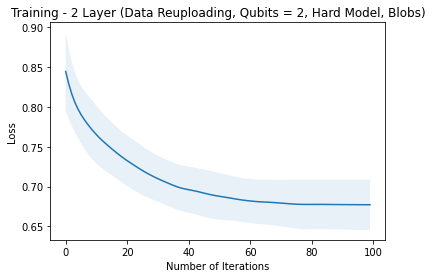

In [14]:
import matplotlib.pyplot as plt
groen = np.array([0,208,0])/255
stddevs =[]
averages =[]
sd = np.std(loss, axis=0)
av = np.average(loss, axis=0)
plt.plot(range(100), av)
plt.fill_between(range(100), av+np.array(sd), av-np.array(sd), alpha=0.1)
stddevs.append(sd)
averages.append(av)

plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.title("Training - 2 Layer (Data Reuploading, Qubits = 2, Hard Model, Blobs)")

In [16]:
losseasy = np.zeros((100,100))
for i in range(100):
    file = 'Data/2Layers/Layer2Easy/quantum_loss_easy_layer2blobs_%d.npy'%i
    losseasy[i] += np.load(file, allow_pickle=True)

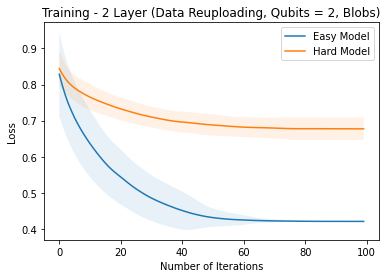

In [17]:
stddevs =[]
averages =[]
sde = np.std(losseasy, axis=0)
ave = np.average(losseasy, axis=0)
plt.plot(range(100), ave)
plt.fill_between(range(100), ave+np.array(sde), ave-np.array(sde), alpha=0.1)
stddevs.append(sde)
averages.append(ave)

plt.plot(range(100), av)
plt.fill_between(range(100), av+np.array(sd), av-np.array(sd), alpha=0.1)

plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.title("Training - 2 Layer (Data Reuploading, Qubits = 2, Blobs)")

legendList = ['{}'.format(i) for i in ["Easy Model", "Hard Model"]]
plt.legend(legendList)